In [7]:
library(devtools)

In [8]:
devtools::install_github("shichenxie/scorecard")


✔  checking for file ‘/private/var/folders/3b/h_r8tfg962n2mtbypft3vt1m0000gn/T/RtmpGId0d0/remotes10e3a36d8a62f/ShichenXie-scorecard-54a2d96/DESCRIPTION’ ...
─  preparing ‘scorecard’:
✔  checking DESCRIPTION meta-information ...
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘scorecard_0.2.5.999.tar.gz’
   


In [10]:
# Traditional Credit Scoring Using Logistic Regression
library(scorecard)

In [11]:
# data preparing ------
# load germancredit data
data("germancredit")
# filter variable via missing rate, iv, identical value rate
dt_f = var_filter(germancredit, y="creditability")
# breaking dt into train and test
dt_list = split_df(dt_f, y="creditability", ratio = 0.6, seed = 30)
label_list = lapply(dt_list, function(x) x$creditability)

[INFO] filtering variables ... 


[INFO] creating woe binning ... 


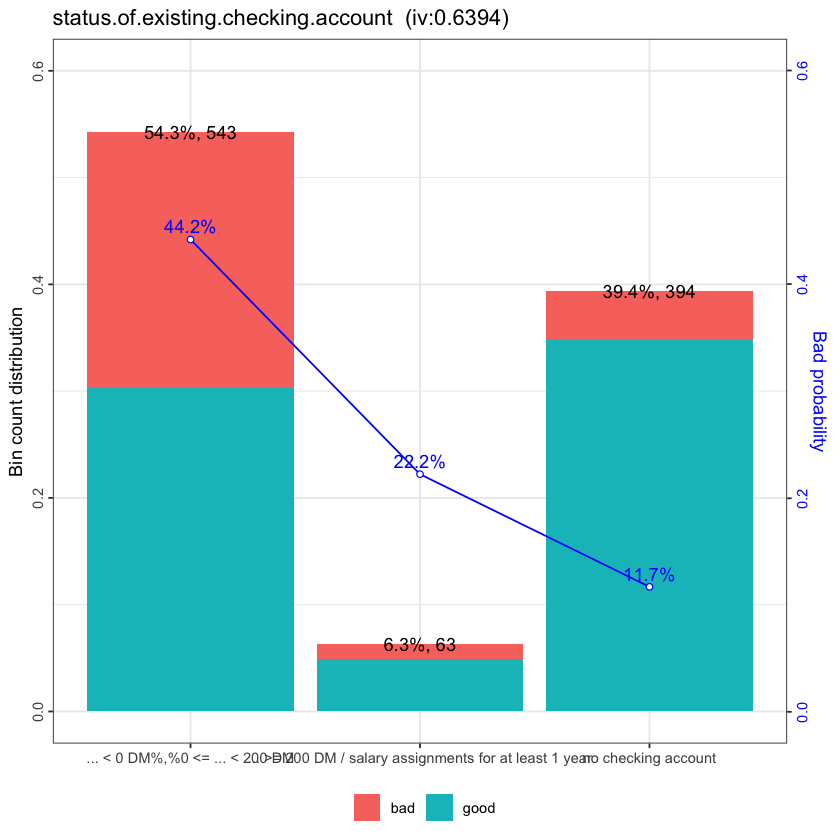

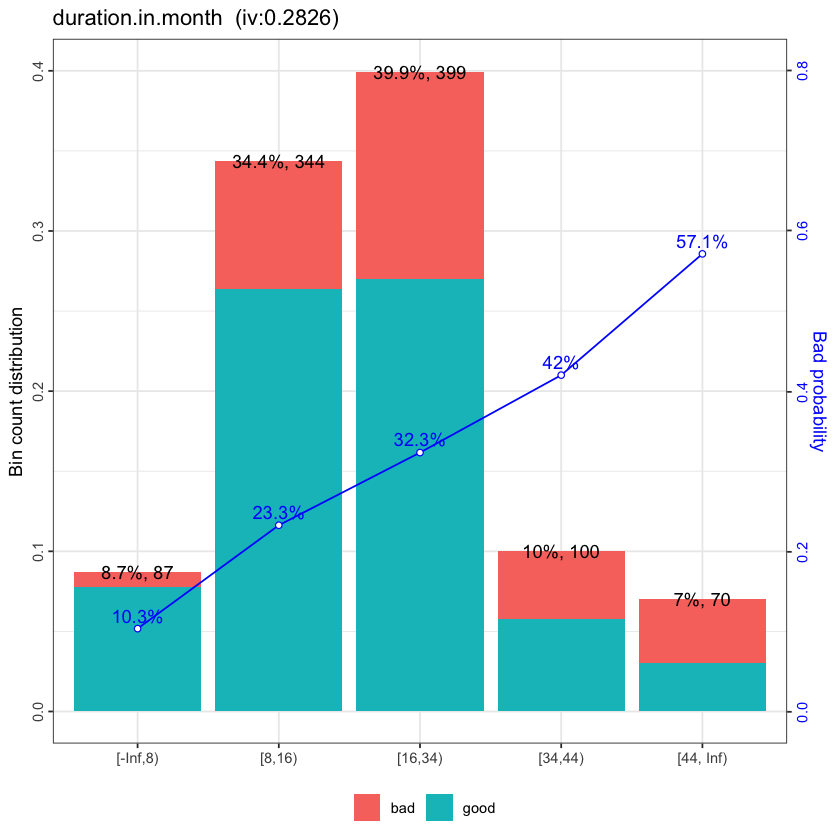

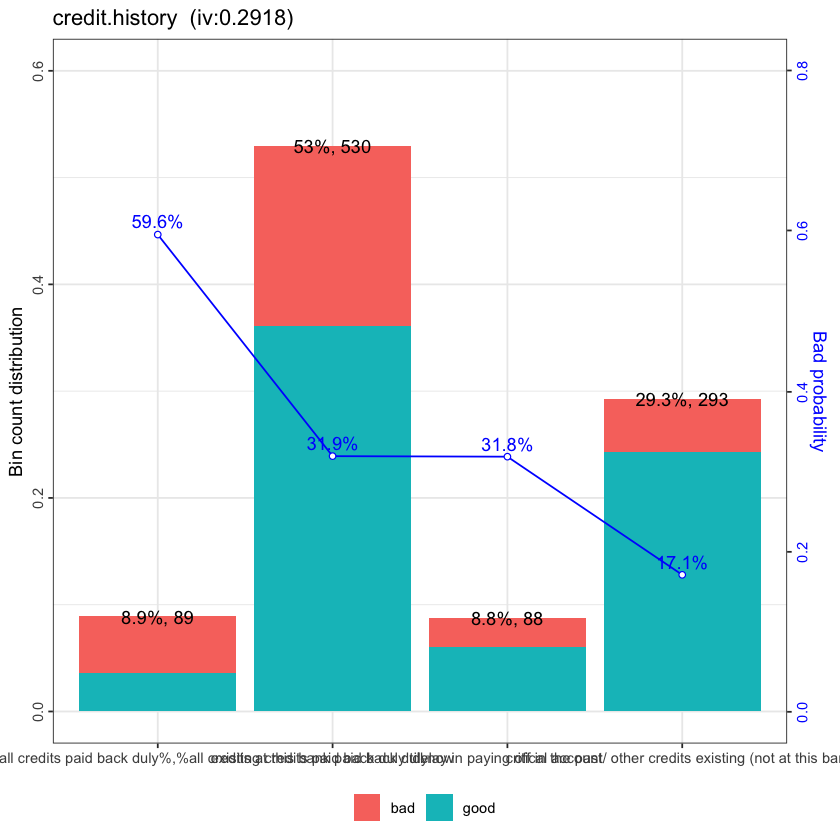

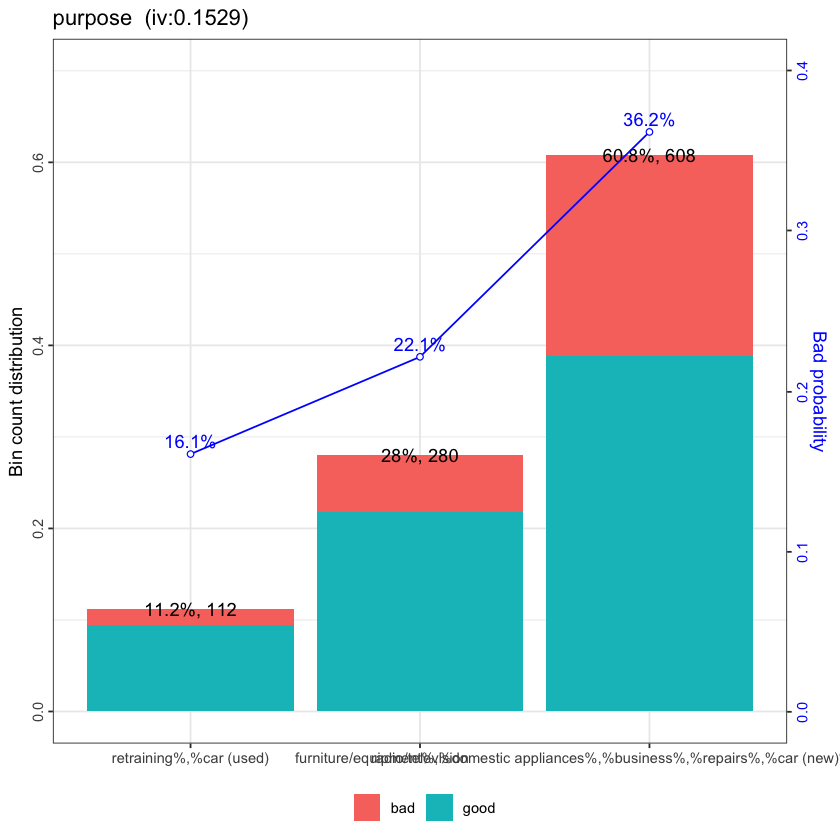

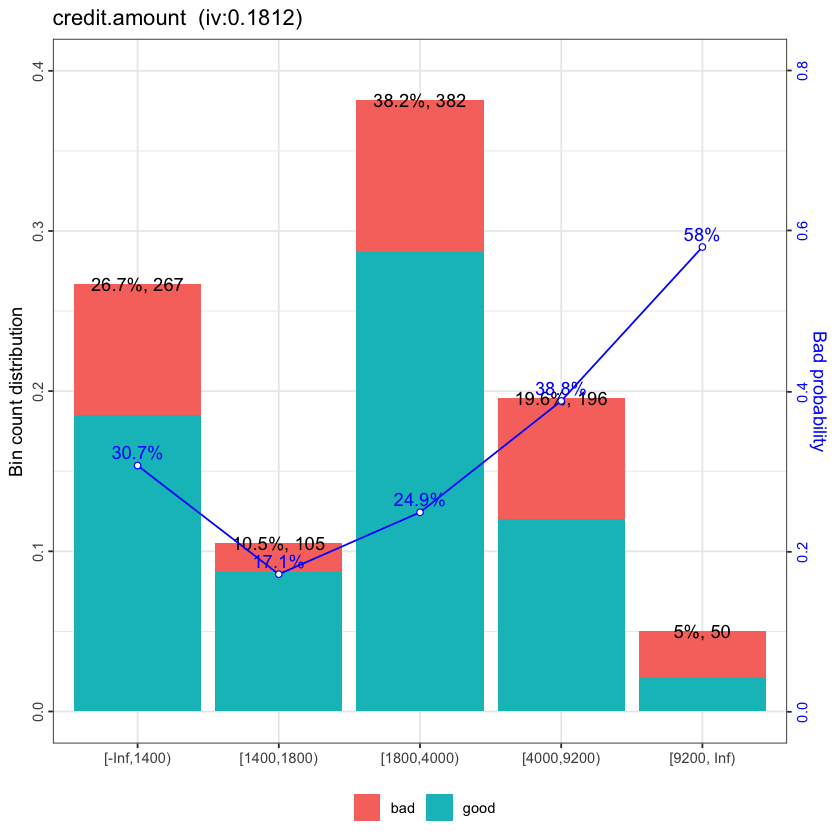

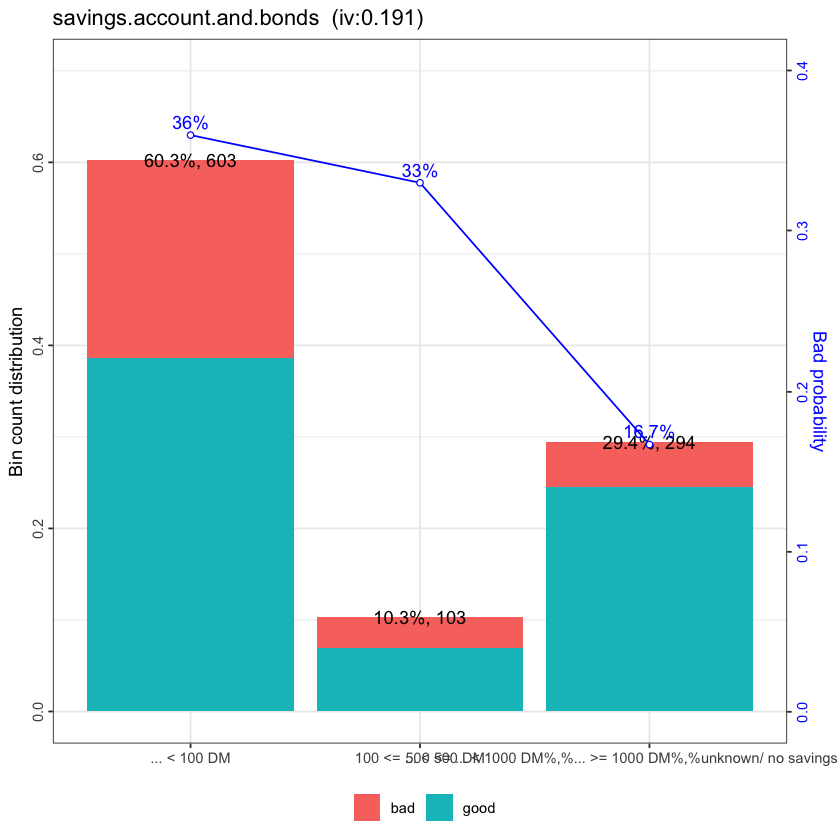

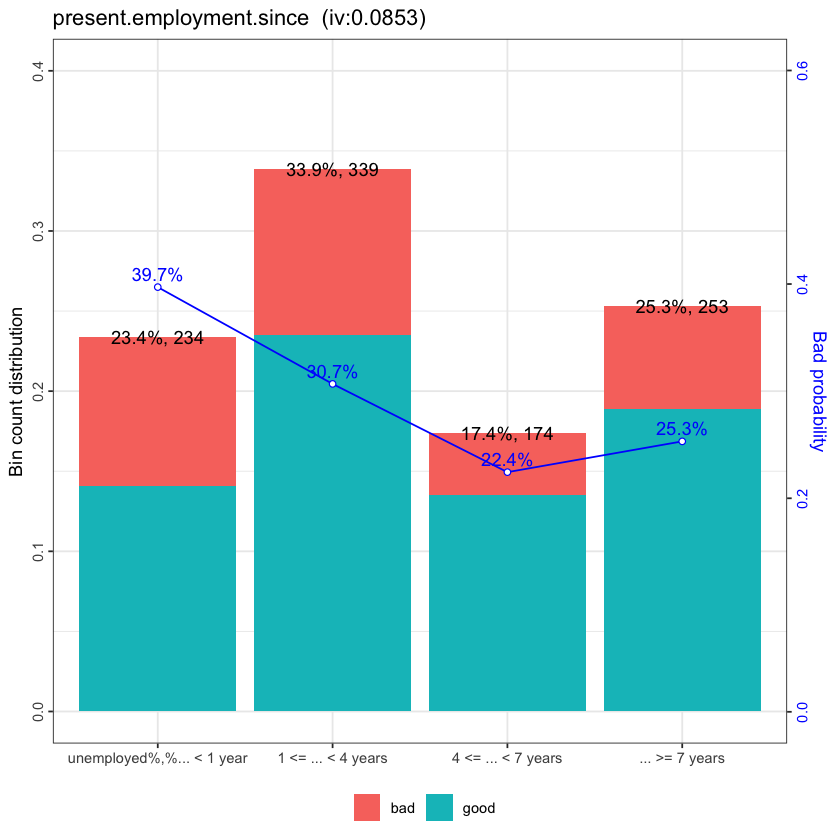

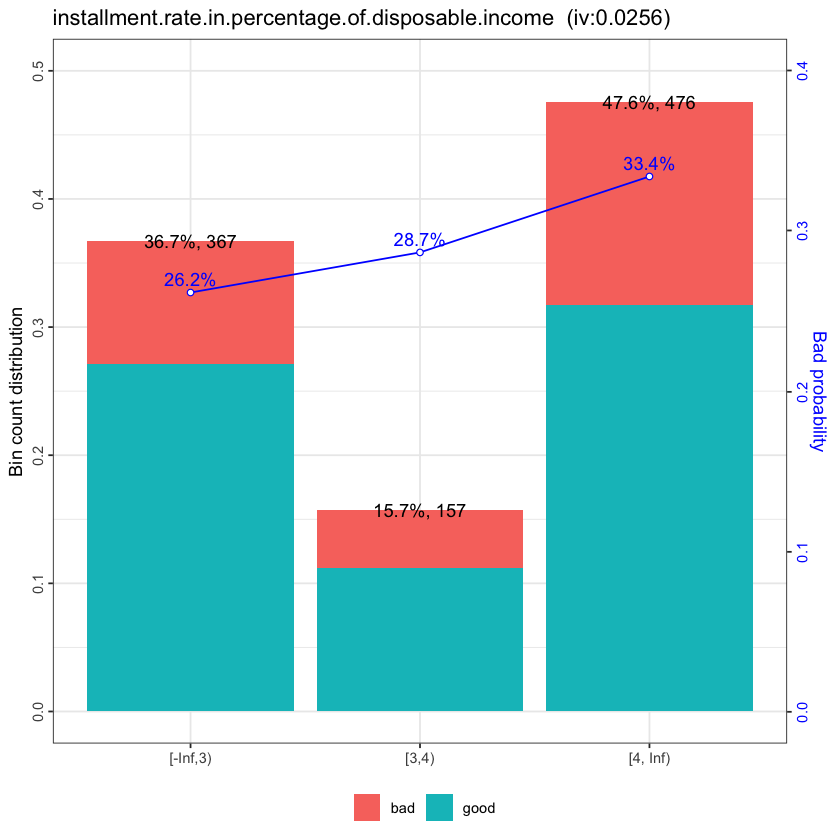

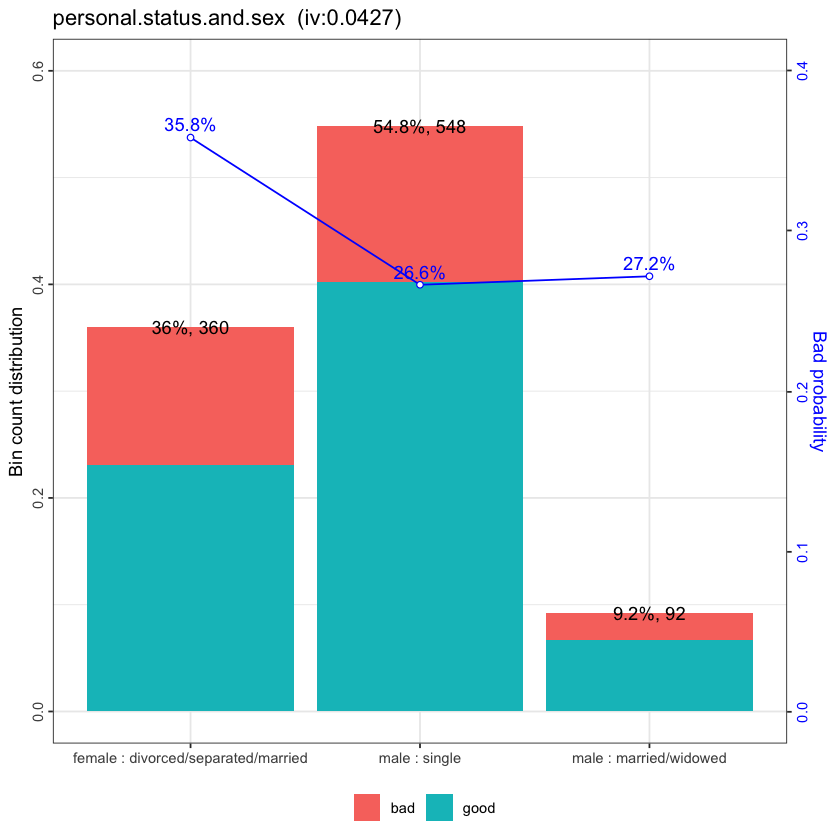

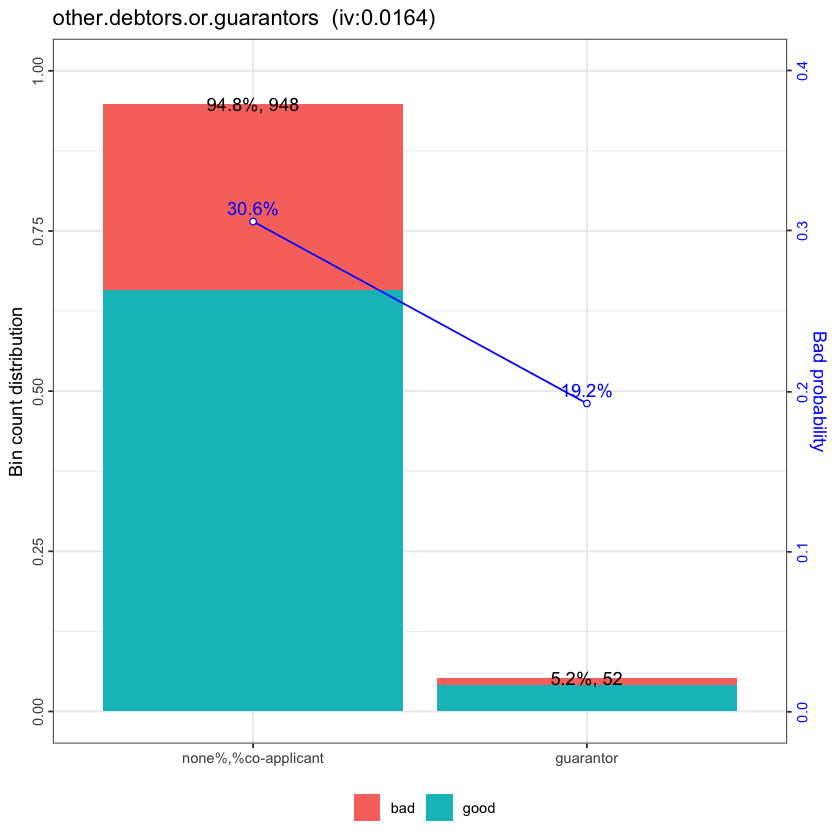

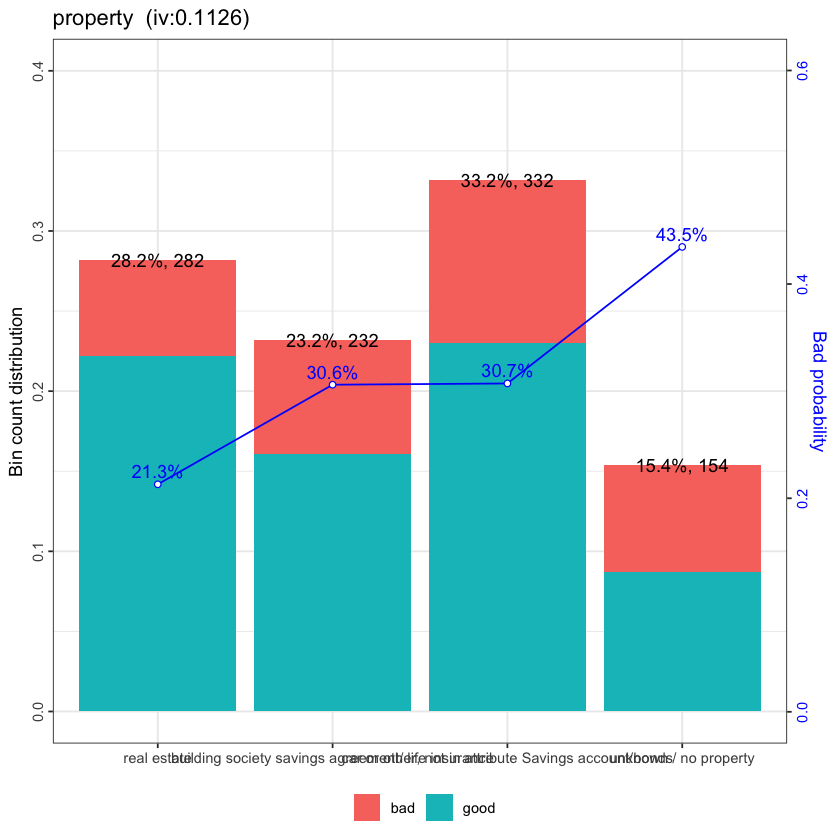

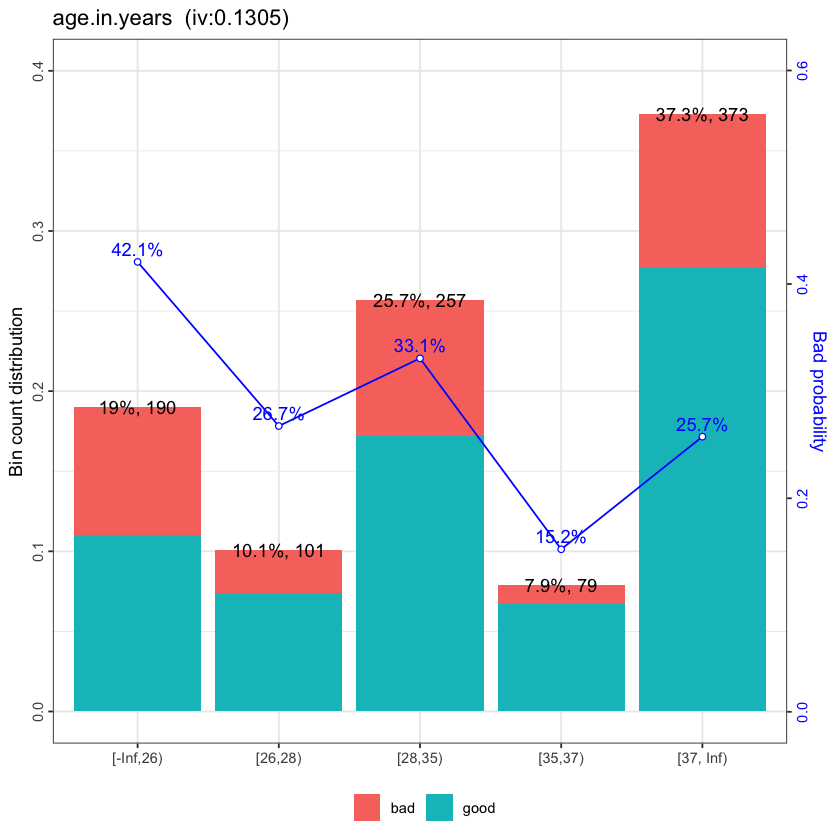

$status.of.existing.checking.account

$duration.in.month

$credit.history

$purpose

$credit.amount

$savings.account.and.bonds

$present.employment.since

$installment.rate.in.percentage.of.disposable.income

$personal.status.and.sex

$other.debtors.or.guarantors

$property

$age.in.years

$other.installment.plans

$housing


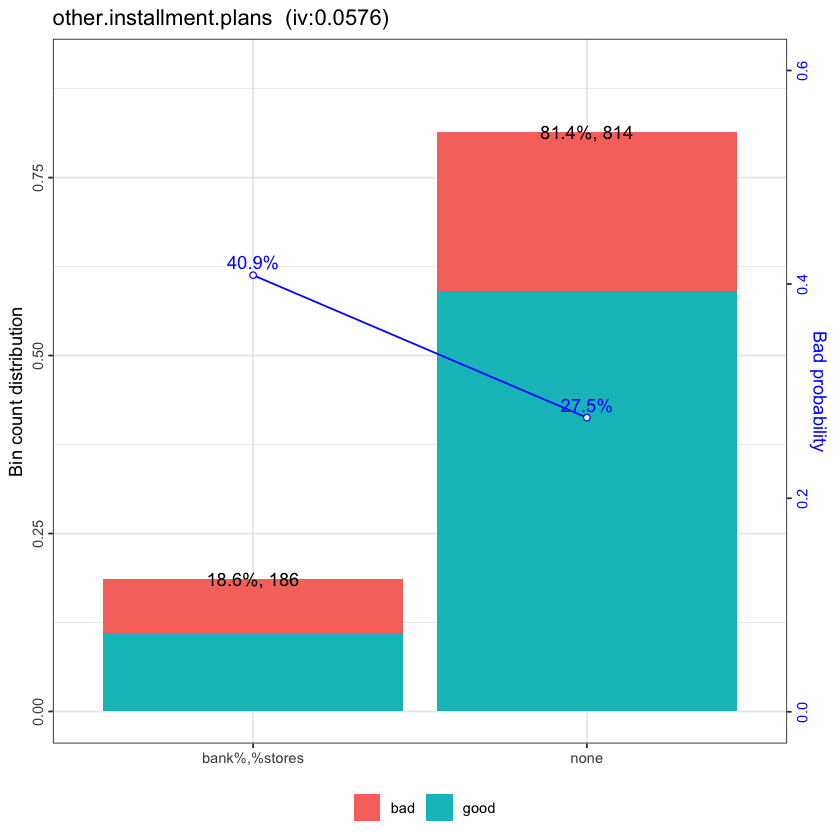

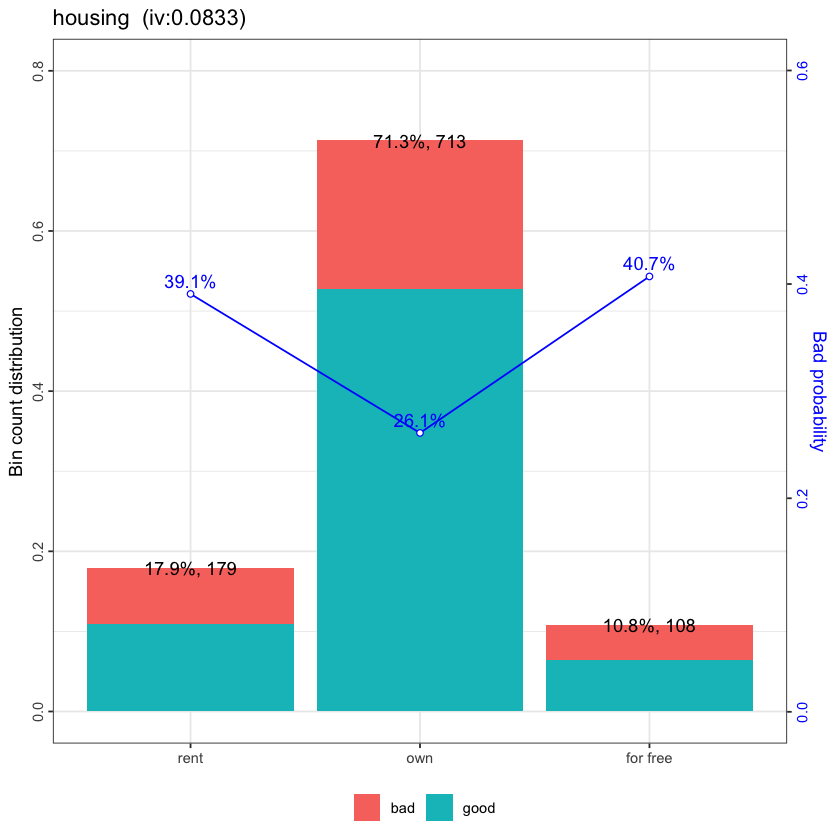

In [12]:
# woe binning ------
bins = woebin(dt_f, y="creditability")
woebin_plot(bins)

In [13]:
# binning adjustment
## adjust breaks interactively
# breaks_adj = woebin_adj(dt_f, "creditability", bins) 
## or specify breaks manually
breaks_adj = list(
  age.in.years=c(26, 35, 40),
  other.debtors.or.guarantors=c("none", "co-applicant%,%guarantor"))
bins_adj = woebin(dt_f, y="creditability", breaks_list=breaks_adj)

[INFO] creating woe binning ... 


Warning message in check_breaks_list(breaks_list, xs):
“There are 12 x variables that donot specified in breaks_list are using optimal binning.”

In [14]:
# converting train and test into woe values
dt_woe_list = lapply(dt_list, function(x) woebin_ply(x, bins_adj))

[INFO] converting into woe values ... 
[INFO] converting into woe values ... 


In [15]:
# glm ------
m1 = glm( creditability ~ ., family = binomial(), data = dt_woe_list$train)
# vif(m1, merge_coef = TRUE) # summary(m1)
# Select a formula-based model by AIC (or by LASSO for large dataset)
m_step = step(m1, direction="both", trace = FALSE)
m2 = eval(m_step$call)
vif(m2, merge_coef = TRUE) # summary(m2)

variable,Estimate,Std. Error,z value,Pr(>|z|),gvif
(Intercept),-0.9432390,0.1089,-8.6625,0.0000,NA
status.of.existing.checking.account_woe,0.7417293,0.1375,5.3952,0.0000,1.034117
duration.in.month_woe,0.8310850,0.2285,3.6370,0.0003,1.187039
credit.history_woe,0.8001445,0.2038,3.9258,0.0001,1.067024
purpose_woe,0.8732312,0.2744,3.1821,0.0015,1.036037
credit.amount_woe,0.8189597,0.2847,2.8768,0.0040,1.243589
savings.account.and.bonds_woe,0.7877819,0.2583,3.0504,0.0023,1.034380
installment.rate.in.percentage.of.disposable.income_woe,1.9872914,0.6819,2.9145,0.0036,1.103374
personal.status.and.sex_woe,0.9810772,0.5304,1.8495,0.0644,1.116737
age.in.years_woe,0.8857061,0.3261,2.7163,0.0066,1.091485


[INFO] The threshold of confusion matrix is 0.3452.


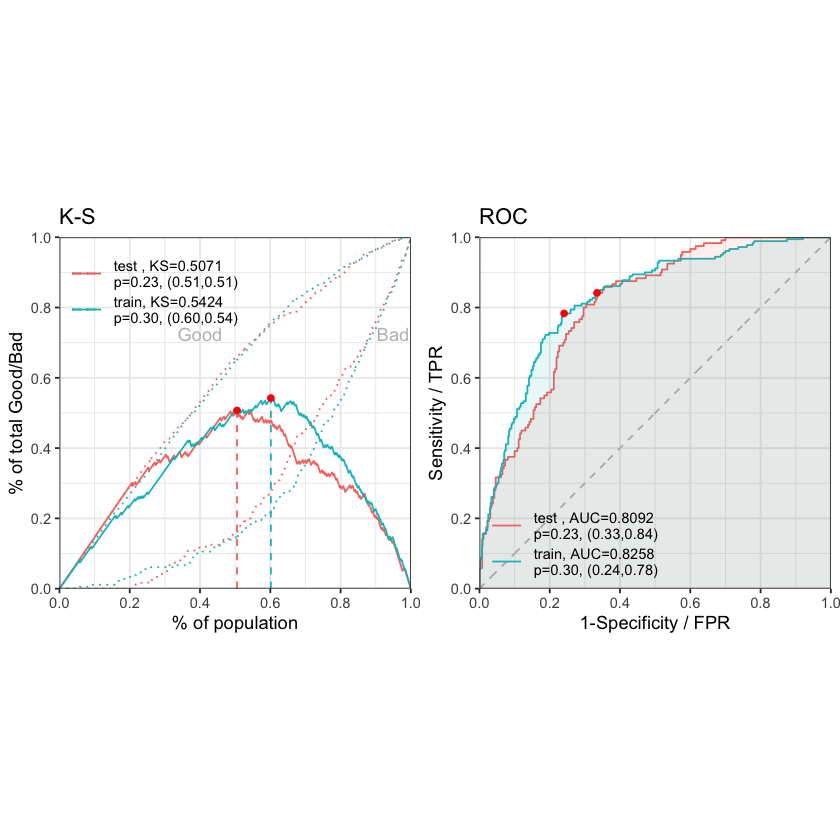

In [16]:
# performance ks & roc ------
## predicted proability
pred_list = lapply(dt_woe_list, function(x) predict(m2, x, type='response'))
## performance
perf = perf_eva(pred = pred_list, label = label_list)

$pic
$pic$score


$psi
   variable    dataset        psi
1:    score train_test 0.01391449


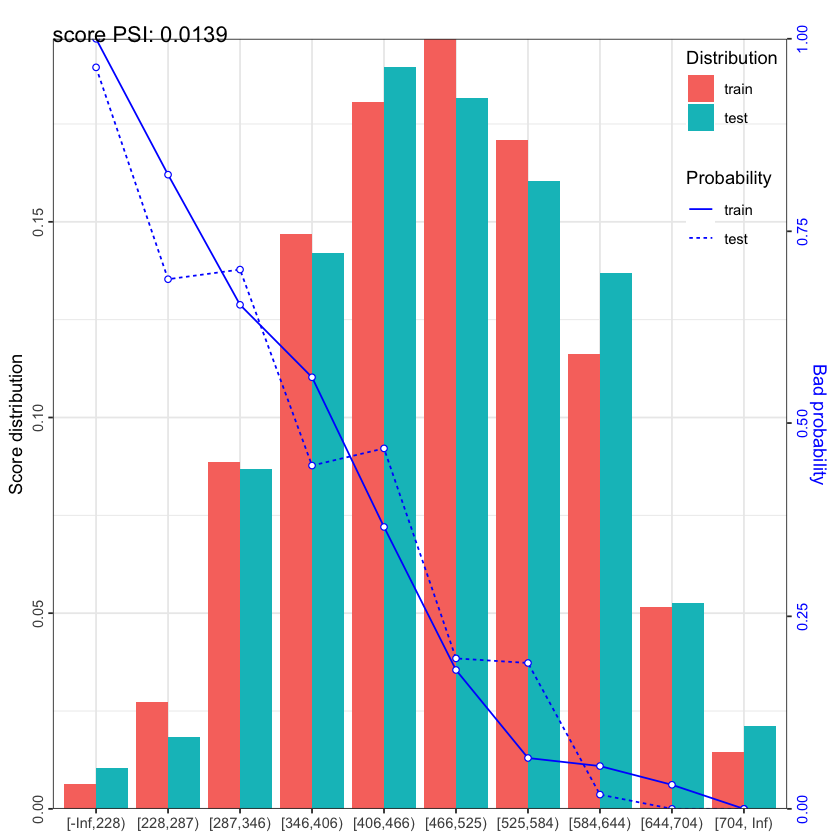

In [17]:
# score ------
## scorecard
card = scorecard(bins_adj, m2)
## credit score
score_list = lapply(dt_list, function(x) scorecard_ply(x, card))
## psi
perf_psi(score = score_list, label = label_list)

In [18]:
card

$basepoints
     variable bin woe points
1: basepoints  NA  NA    456

$status.of.existing.checking.account
                              variable
1: status.of.existing.checking.account
2: status.of.existing.checking.account
3: status.of.existing.checking.account
                                                      bin count count_distr
1:                         ... < 0 DM%,%0 <= ... < 200 DM   543       0.543
2: ... >= 200 DM / salary assignments for at least 1 year    63       0.063
3:                                    no checking account   394       0.394
   good bad   badprob        woe      bin_iv total_iv
1:  303 240 0.4419890  0.6142040 0.225500603 0.639372
2:   49  14 0.2222222 -0.4054651 0.009460853 0.639372
3:  348  46 0.1167513 -1.1762632 0.404410499 0.639372
                                                   breaks is_special_values
1:                         ... < 0 DM%,%0 <= ... < 200 DM             FALSE
2: ... >= 200 DM / salary assignments for at least 1 year             FALSE
3:                                    no checking account             FALSE
   points
1:    -33
2:     22
3:     63

$duration.in.month
            variable       bin count count_distr good bad   badprob        woe
1: duration.in.month  [-Inf,8)    87       0.087   78   9 0.1034483 -1.3121864
2: duration.in.month    [8,16)   344       0.344  264  80 0.2325581 -0.3466246
3: duration.in.month   [16,34)   399       0.399  270 129 0.3233083  0.1086883
4: duration.in.month   [34,44)   100       0.100   58  42 0.4200000  0.5245245
5: duration.in.month [44, Inf)    70       0.070   30  40 0.5714286  1.1349799
        bin_iv  total_iv breaks is_special_values points
1: 0.106849463 0.2826181      8             FALSE     79
2: 0.038293766 0.2826181     16             FALSE     21
3: 0.004813339 0.2826181     34             FALSE     -7
4: 0.029972827 0.2826181     44             FALSE    -31
5: 0.102688661 0.2826181    Inf             FALSE    -68

$credit.history
         variable
1: credit.history
2: credit.history
3: credit.history
4: credit.history
                                                                                      bin
1: no credits taken/ all credits paid back duly%,%all credits at this bank paid back duly
2:                                               existing credits paid back duly till now
3:                                                        delay in paying off in the past
4:                            critical account/ other credits existing (not at this bank)
   count count_distr good bad   badprob         woe       bin_iv  total_iv
1:    89       0.089   36  53 0.5955056  1.23407084 0.1545526808 0.2918299
2:   530       0.530  361 169 0.3188679  0.08831862 0.0042056484 0.2918299
3:    88       0.088   60  28 0.3181818  0.08515781 0.0006488214 0.2918299
4:   293       0.293  243  50 0.1706485 -0.73374058 0.1324227042 0.2918299
                                                                                   breaks
1: no credits taken/ all credits paid back duly%,%all credits at this bank paid back duly
2:                                               existing credits paid back duly till now
3:                                                        delay in paying off in the past
4:                            critical account/ other credits existing (not at this bank)
   is_special_values points
1:             FALSE    -71
2:             FALSE     -5
3:             FALSE     -5
4:             FALSE     42

$purpose
   variable
1:  purpose
2:  purpose
3:  purpose
                                                                                               bin
1:                                                                         retraining%,%car (used)
2:                                                                                radio/television
3: furniture/equipment%,%domestic appliances%,%business%,%repairs%,%car (new)%,%others%,%education
   count count_distr good bad   badprob        woe     bin_i